# Differential expression and celltype analysis [All Cell]

1. Differential gene expression (DGE) analysis identifies genes that show statistically significant differences in expression levels across distinct cell populations or conditions. This analysis helps in identifying which cell types are most affected by a condition of interest such as a disease, and characterizing their functional signatures.

2. Differential Compositional analysis identifies Quantifies changes in the relative abundances of each cell type across conditions (e.g., case vs. control, time points, treatment groups). Reveals expansions or contractions of specific populations that may not be captured by gene-level analyses alone.

Here, we introduced `omicverse.single.DEG` and `omicverse.single.DCT` to performed these two analysis.

In [15]:
import scanpy as sc
#import pertpy as pt
import omicverse as ov
ov.style()

🔬 Starting plot initialization...
🧬 Detecting GPU devices…
✅ Apple Silicon MPS detected
    • [MPS] Apple Silicon GPU - Metal Performance Shaders available
✅ plot_set complete.



## Data Preprocess

The data we use in the following example comes from [Haber et al., 2017]. It contains samples from the small intestinal epithelium of mice with different conditions. We first load the raw cell-level data. The dataset contains gene expressions of 9842 cells. They are annotated with their sample identifier (`batch`), the condition of the subjects and the type of each cell (`cell_label`).

In [3]:
adata = pt.dt.haber_2017_regions()
adata

AnnData object with n_obs × n_vars = 9842 × 15215
    obs: 'batch', 'barcode', 'condition', 'cell_label'

For our first example, we want to look at how the `Salmonella` infection influences the cell composition. Therefore, we create a subset of our compositional data that only contains the `healthy` and `Salmonella-infected` samples as a new data modality.

In [4]:
# Select control and salmonella data
adata = adata[
    adata.obs["condition"].isin(["Control", "Salmonella"])
].copy()
print(adata)

AnnData object with n_obs × n_vars = 5010 × 15215
    obs: 'batch', 'barcode', 'condition', 'cell_label'


In [5]:
adata.obs["condition"].unique()

['Control', 'Salmonella']
Categories (2, object): ['Control', 'Salmonella']

## DEG with wilcoxon/t-test

In omicverse, we only need one function `ov.single.DEG` to perfrom all DEG analysis tasks. First, I will introduce the nonparametric Wilcoxon test and the t-test—two widely used methods for differential expression analysis. Due to their high computational efficiency, we applied them in our DEG analysis.

We need to set the `ctrl_group` and `test_group` to perform the analysis. Besides, we also need to define the celltype to be explode. If you set `celltype_group` is None, all the celltype will be calculated.

In [4]:
deg_obj=ov.single.DEG(
    adata,
    condition='condition',
    ctrl_group='Control',
    test_group='Salmonella',
    method='wilcoxon',
)
deg_obj.run(
    celltype_key='cell_label',
    celltype_group=['TA'],
)


✅ Differential expression analysis initialized
📊 DEG analysis using wilcoxon method
📊 Condition: condition, Control group: Control, Test group: Salmonella
📊 Celltype key: cell_label, Celltype group: ['TA']
Total cells: 533 will be used for DEG analysis
normalizing counts per cell
    finished (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
✅ wilcoxon DEG analysis completed


In [5]:
res_wilcoxon=deg_obj.get_results()
res_wilcoxon.head()

,log2FC,pvalue,padj,qvalue,size,sig,-log(pvalue),-log(qvalue)
Reg3b,5.958403,2.899264e-58,4.411230e-54,4.411230e-54,0.595840,sig,57.537712,53.355440
Reg3g,4.425004,1.576382e-51,1.199233e-47,1.199233e-47,0.442500,sig,50.802339,46.921097
Apoa1,2.589844,2.025723e-40,1.027379e-36,1.027379e-36,0.258984,sig,39.693420,35.988269
Guca2b,2.380329,1.732794e-21,5.272893e-18,5.272893e-18,0.238033,sig,20.761253,17.277951
Zg16,2.077089,2.553716e-21,6.475798e-18,6.475798e-18,0.207709,sig,20.592827,17.188707


We can use `sc.pl.violin` to compare the gene expression between different condition.

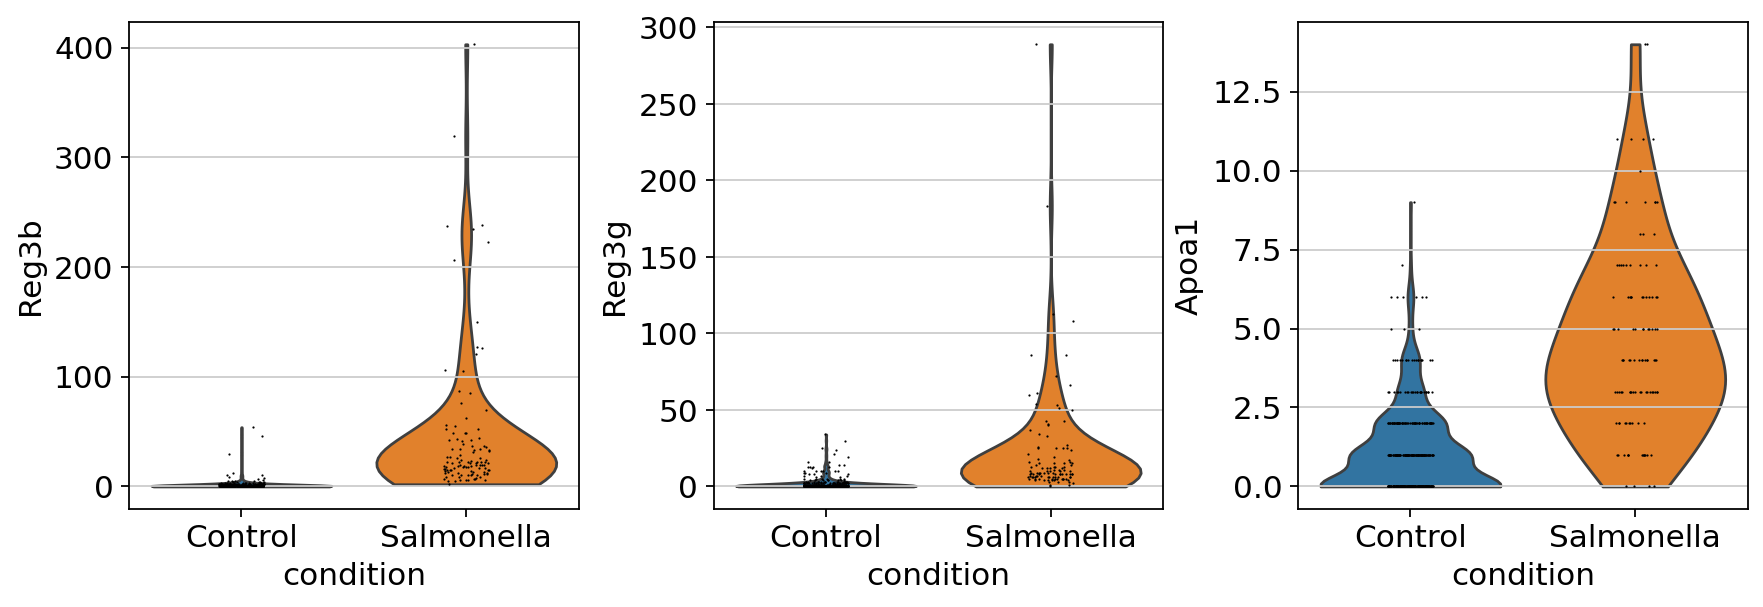

In [19]:
celltypes_li=['TA']

sc.pl.violin(
    adata[adata.obs['cell_label'].isin(celltypes_li)],
    keys=['Reg3b','Reg3g','Apoa1'],
    groupby='condition'
)

## DEG with memento

memento is a python package for performing differential mean, variability, and correlation in single-cell RNA sequencing data.

Memento, an end-to-end method that implements a hierarchical model for estimating mean, residual variance, and gene correlation from scRNA-seq data and provides a statistical framework for hypothesis testing of these parameters.


In [8]:
deg_obj=ov.single.DEG(
    adata,
    condition='condition',
    ctrl_group='Control',
    test_group='Salmonella',
    method='memento-de',
)
deg_obj.run(
    celltype_key='cell_label',
    celltype_group=['TA'],
    capture_rate=0.07, 
    num_cpus=12,
    num_boot=5000
)


✅ Differential expression analysis initialized
📊 DEG analysis using memento-de method
📊 Condition: condition, Control group: Control, Test group: Salmonella
📊 Celltype key: cell_label, Celltype group: ['TA']
Total cells: 533 will be used for DEG analysis


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    8.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   11.8s
[Parallel(n_jobs=12)]: Done 528 tasks      | elapsed:   15.3s
[Parallel(n_jobs=12)]: Done 1228 tasks      | elapsed:   20.2s
[Parallel(n_jobs=12)]: Done 2128 tasks      | elapsed:   26.2s
[Parallel(n_jobs=12)]: Done 3228 tasks      | elapsed:   34.0s
[Parallel(n_jobs=12)]: Done 4521 out of 4544 | elapsed:   42.8s remaining:    0.2s
[Parallel(n_jobs=12)]: Done 4544 out of 4544 | elapsed:   42.9s finished


✅ memento-de DEG analysis completed


In [17]:
res_memento=deg_obj.get_results()
res_memento.query('dv_coef > 1 & de_coef > 0').sort_values('dv_pval').head(5)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
443,Btf3,stim,0.838806,0.230108,0.000213,2.940342,0.580788,4.519054e-07
397,Birc5,stim,0.631178,0.185273,0.000661,1.198823,0.313596,8.280704e-05
3421,Serinc2,stim,0.030935,0.238055,0.826321,2.288608,0.511458,1.560657e-04
917,Dcaf8,stim,0.037631,0.316794,0.846642,1.833301,0.500972,2.687823e-04
536,Ccnb2,stim,0.132247,0.234056,0.565606,1.126923,0.323989,3.477457e-04


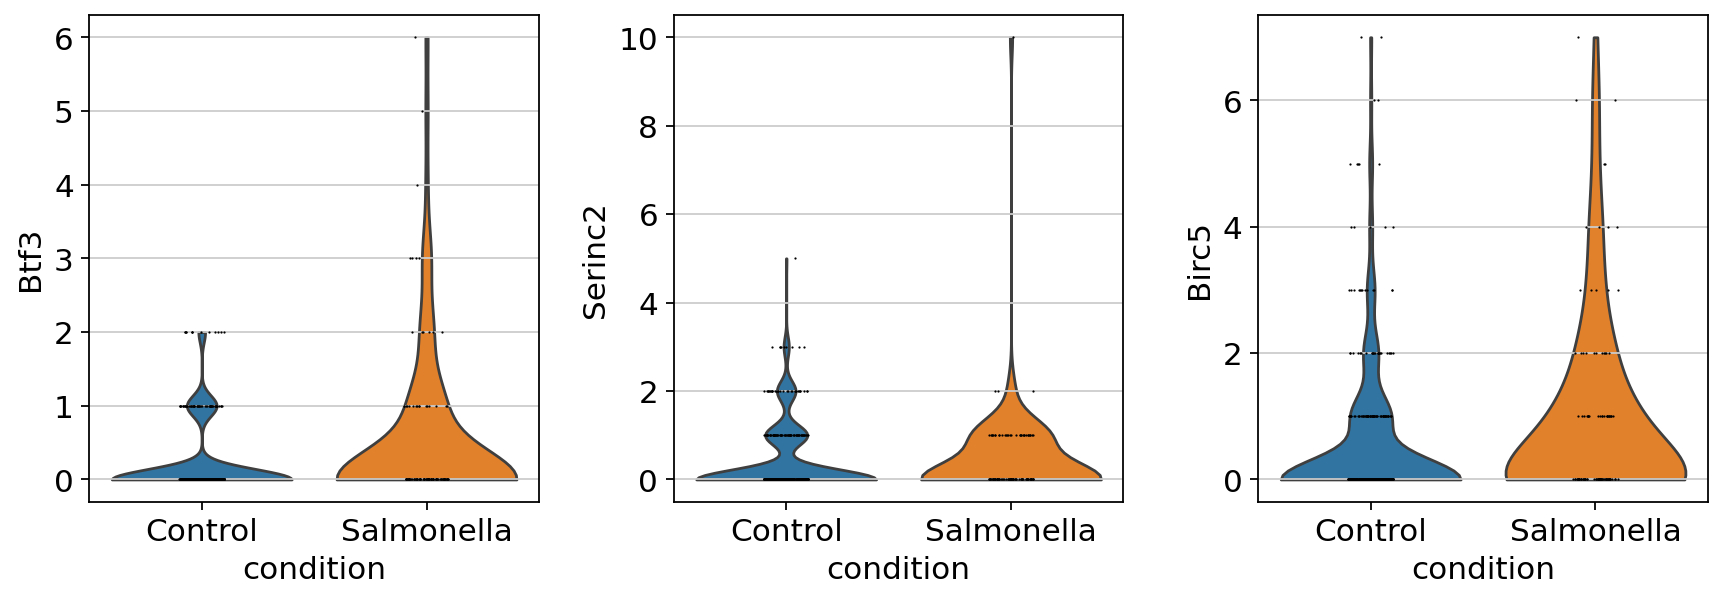

In [18]:
celltypes_li=['TA']

sc.pl.violin(
    adata[adata.obs['cell_label'].isin(celltypes_li)],
    keys=['Btf3','Serinc2','Birc5'],
    groupby='condition'
)

## DCT with scCODA

In omicverse, we only need one function `ov.single.DCT` to perfrom all DCT analysis tasks. We included `scCODA` and `milo` to perform the celltype abundance analysis.

Besides, you can also perform the analysis with `pertpy`'s api. `dct_obj.model` will be helpful.

More tutorial could be found in https://pertpy.readthedocs.io/en/stable/tutorials/notebooks/sccoda.html

In [7]:
dct_obj=ov.single.DCT(
    adata,
    condition='condition',
    ctrl_group='Control',
    test_group='Salmonella',
    cell_type_key='cell_label',
    method='sccoda',
    sample_key='batch',
)

• Automatic reference selection! Reference cell type set to Endocrine


No-U-turn HMC sampling is then initiated by calling sccoda_model.`run_nuts`().

We can use `help(dct_obj.model.run_nuts)` to obtain the argument as input.

In [9]:
dct_obj.run(
    num_samples=5000, #number of sampled values after burn-in.
    num_warmup=500, #Number of burn-in (warmup) samples.
)

sample: 100%|██████████| 5500/5500 [03:17<00:00, 27.79it/s, 127 steps of size 2.91e-02. acc. prob=0.76]


In [10]:
res=dct_obj.get_results()
res.head()

Final Parameter  HDI 3%  HDI 97%  \
Covariate             Cell Type                                                 
conditionT.Salmonella Endocrine                     0.000000   0.000    0.000   
                      Enterocyte                    1.367619   0.864    1.886   
                      Enterocyte.Progenitor         0.000000  -0.393    0.647   
                      Goblet                        0.000000  -0.228    1.037   
                      Stem                          0.000000  -0.750    0.251   

                                                SD  Inclusion probability  \
Covariate             Cell Type                                             
conditionT.Salmonella Endocrine              0.000                 0.0000   
                      Enterocyte             0.262                 1.0000   
                      Enterocyte.Progenitor  0.163                 0.3072   
                      Goblet                 0.298                 0.4688   
                      Stem                   0.199                 0.3560   

                                             Expected Sample  log2-fold change  
Covariate             Cell Type                                                 
conditionT.Salmonella Endocrine                    25.782816         -0.495162  
                      Enterocyte                  325.488661          1.477896  
                      Enterocyte.Progenitor       100.454836         -0.495162  
                      Goblet                       43.541227         -0.495162  
                      Stem                        120.266274         -0.495162

### Adjusting the False discovery rate

scCODA selects credible effects based on their inclusion probability. The cutoff between credible and non-credible effects depends on the desired false discovery rate (FDR). A smaller FDR value will produce more conservative results, but might miss some effects, while a larger FDR value selects more effects at the cost of a larger number of false discoveries.

The desired FDR level can be easily set after inference via sim_results.set_fdr(). Per default, the value is 0.05, but we recommend to increase it up to 0.2 if no effects are found at a more conservative level.

In our example, setting a desired FDR of 0.4 reveals small effects on Endocrine and Tuft cells. Keep in mind that we chose this value only for instructive purposes, since there are no credible effects beside Enterocytes at lower FDR levels. In practice, expecting 40% of all credible effects to be false-positives is usually not recommended.

In [23]:
dct_obj.model.set_fdr(dct_obj.sccoda_data, 
                      modality_key="coda", 
                      est_fdr=0.6)
res=dct_obj.get_results()
res.sort_values('Final Parameter',ascending=False).head()

Final Parameter  HDI 3%  HDI 97%  \
Covariate             Cell Type                                                 
conditionT.Salmonella Enterocyte                    1.367619   0.864    1.886   
                      Goblet                        0.353104  -0.228    1.037   
                      Enterocyte.Progenitor         0.115878  -0.393    0.647   
                      TA.Early                      0.008501  -0.408    0.486   
                      Endocrine                     0.000000   0.000    0.000   

                                                SD  Inclusion probability  \
Covariate             Cell Type                                             
conditionT.Salmonella Enterocyte             0.262                 1.0000   
                      Goblet                 0.298                 0.4688   
                      Enterocyte.Progenitor  0.163                 0.3072   
                      TA.Early               0.121                 0.2748   
                      Endocrine              0.000                 0.0000   

                                             Expected Sample  log2-fold change  
Covariate             Cell Type                                                 
conditionT.Salmonella Enterocyte                  327.583710          1.487152  
                      Goblet                       62.378974          0.023516  
                      Enterocyte.Progenitor       113.522620         -0.318729  
                      TA.Early                    142.968607         -0.473642  
                      Endocrine                    25.948771         -0.485906

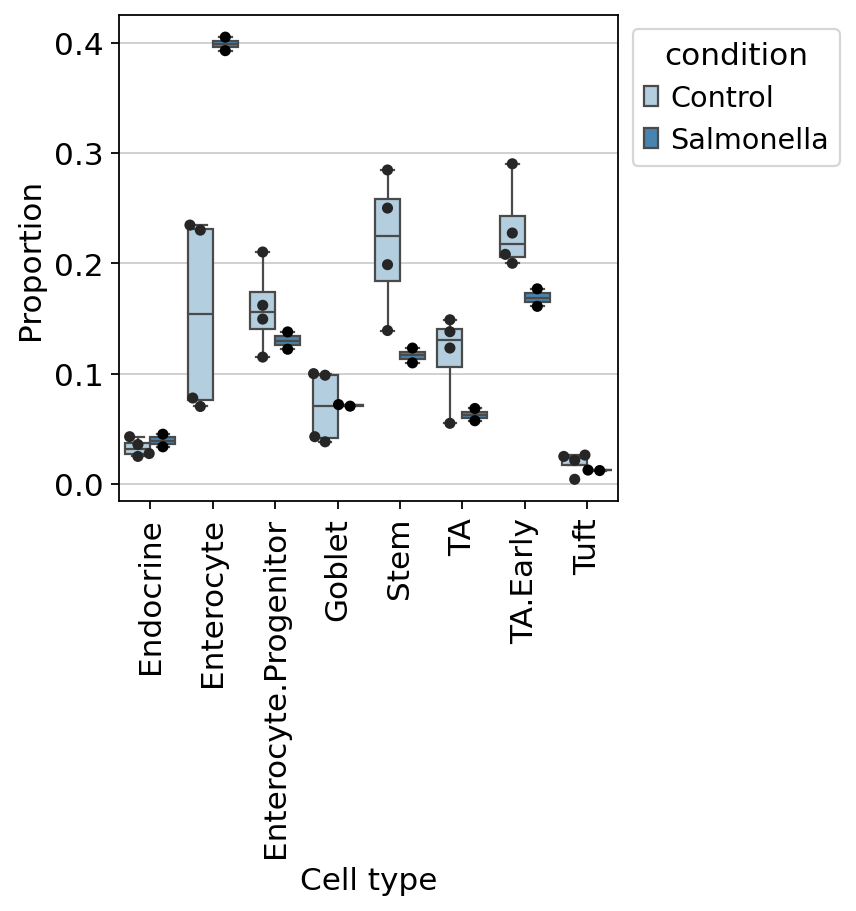

In [20]:
#ov.plot_set()
dct_obj.model.plot_boxplots(
    dct_obj.sccoda_data, 
    modality_key="coda", 
    feature_name="condition", 
    add_dots=True,
    figsize=(4,4),
    dpi=80,
)
ov.plt.show()

In [28]:
dct_obj.model.summary(
    dct_obj.sccoda_data, 
    modality_key="coda"
)

                                          Compositional Analysis summary                                           
┌──────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┐
│ Name                                         │ Value                                                            │
├──────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────┤
│ Data                                         │ Data: 6 samples, 8 cell types                                    │
│ Reference cell type                          │ Endocrine                                                        │
│ Formula                                      │ condition                                                        │
└──────────────────────────────────────────────┴──────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                        Final Parameter  Expected Sample                                                         │
│ Cell Type                                                                                                       │
│ Endocrine                  1.183            36.340                                                              │
│ Enterocyte                 2.351           116.854                                                              │
│ Enterocyte.Progenitor      2.543           141.589                                                              │
│ Goblet                     1.707            61.370                                                              │
│ Stem                       2.723           169.513                                                              │
│ TA                         2.126            93.310                                                              │
│ TA.Early                   2.881           198.528                                                              │
│ Tuft                       0.452            17.495                                                              │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                              Final Parameter  Expected Sample  log2-fold change                 │
│ Covariate             Cell Type                                                                                 │
│ conditionT.Salmonella Endocrine                   0.000           25.949            -0.486                      │
│                       Enterocyte                  1.368          327.584             1.487                      │
│                       Enterocyte.Progenitor       0.116          113.523            -0.319                      │
│                       Goblet                      0.353           62.379             0.024                      │
│                       Stem                       -0.229           96.260            -0.816                      │
│                       TA                         -0.212           53.916            -0.791                      │
│                       TA.Early                    0.009          142.969            -0.474                      │
│                       Tuft                       -0.006           12.421            -0.494                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

## DCT with milopy

Many biological conditions (disease, development, genetic KOs) can induce shifts in cell composition, where cells of a given state become enriched or depleted in response to a perturbation. With differential abundance analysis, we quantify consistent changes in cell composition across replicate samples. While differential abundance analysis can be performed on cell type clusters, it’s not always possible or practical to use precisely labeled clusters, especially when we are interested in studying transitional states, such as during developmental processes, or when we expect only a subpopulation of a cell type to be affected by the condition of interest. Milo is a method to detect compositional changes occurring in smaller subpopulations of cells, defined as neighbourhoods over the k-nearest neighbor (KNN) graph of cell-cell similarities.


### Build KNN graph

We can use omicverse functions to build a KNN graph. We set the dimensionality and value for k to use in subsequent steps.

Here the value of k indicates the smallest possible size of neighbourhood in which we will quantify differential abundance (i.e. with k=50 the smallest neighbourhood will have 50 cells). Depending on the number of samples, you might want to use a high value of k for neighbourhood analysis, to have sufficient power to estimate abundance fold-changes. Since here we have data from > 100 patients, we set k=150 to have on average more than one cell per donor in each neighbourhood.

In [6]:
ov.settings.cpu_gpu_mixed_init()

CPU-GPU mixed mode activated


In [7]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,
                       target_sum=50*1e4)
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
ov.single.batch_correction(adata,batch_key='batch',
                                        methods='harmony',n_pcs=50)
ov.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='X_harmony')
ov.pp.umap(adata)

Begin robust gene identification
After filtration, 15215/15215 genes are kept.     Among 15215 genes, 15215 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['Defa24', 'Fabp6', 'Gcg', 'Gip', 'Nts', 'Reg3b', 'Reg4', 'Sct', 'Spink4', 'Sst', 'Tff3', 'Zg16']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 7.434457540512085 seconds.
End of size normalization: shiftlog and HVGs selection pearson
...Begin using h

2025-05-24 03:28:39,033 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-24 03:28:40,914 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-24 03:28:40,966 - harmonypy - INFO - Iteration 1 of 10
2025-05-24 03:28:42,555 - harmonypy - INFO - Iteration 2 of 10
2025-05-24 03:28:44,190 - harmonypy - INFO - Iteration 3 of 10
2025-05-24 03:28:45,633 - harmonypy - INFO - Iteration 4 of 10
2025-05-24 03:28:46,905 - harmonypy - INFO - Iteration 5 of 10
2025-05-24 03:28:48,659 - harmonypy - INFO - Iteration 6 of 10
2025-05-24 03:28:49,316 - harmonypy - INFO - Converged after 6 iterations


🖥️ Using Scanpy CPU to calculate neighbors...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
🔍 [2025-05-24 03:28:52] Running UMAP in 'cpu-gpu-mixed' mode...
🚀 Using torch GPU to calculate UMAP...
📊 [GPU 0] ------------------------------ 5/12288 MiB (0.0%)
computing UMAP🚀
    finished ✅: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:05)
✅ UMAP completed successfully.


In [2]:
adata=ov.read('data/milo_test.h5ad')

X_umap converted to UMAP to visualize and saved to adata.obsm['UMAP']
if you want to use X_umap, please set convert=False


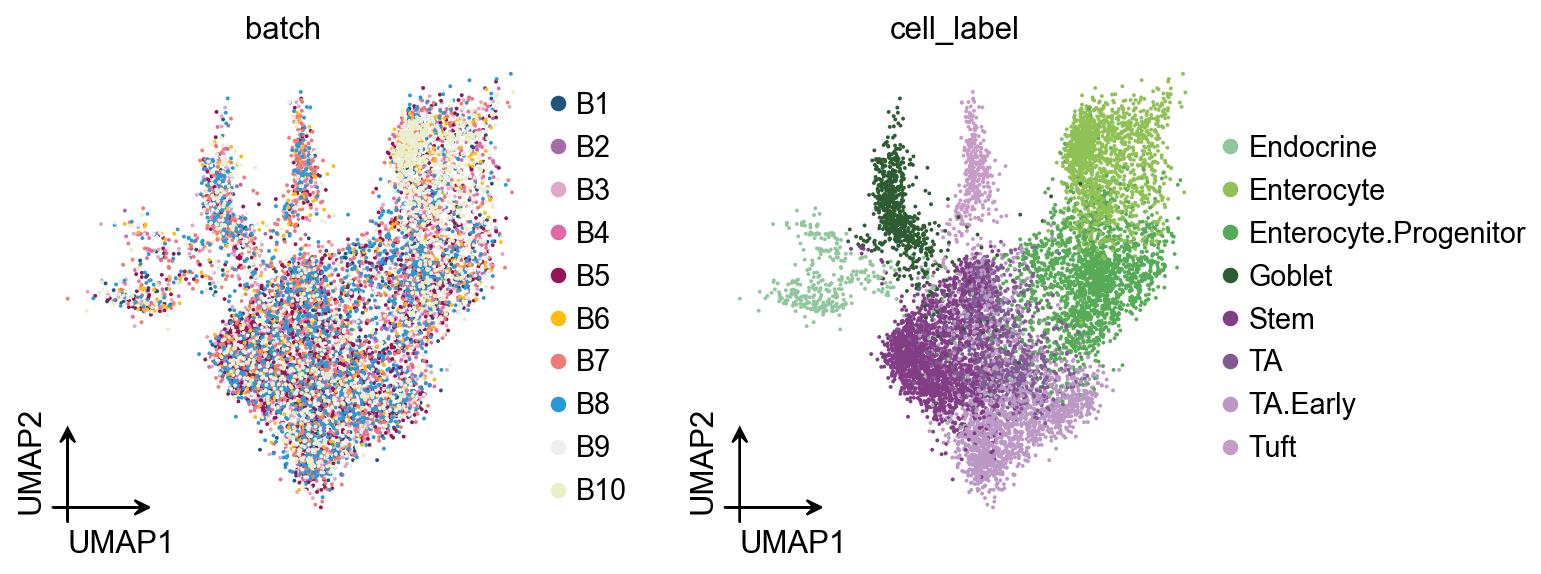

In [17]:
ov.pl.umap(
    adata,
    color=['batch','cell_label'],
)

### Differential abundance testing with GLM

Similar to the scCODA approach, we use `omicverse.single.DCT` to perform differential cell–abundance analysis, except that here we set the `method` to `milopy`. 

In releases after `1.7.9`, we have removed the rpy2‐based `edgeR` dependency so that milo analyses can run entirely in a native Python environment. But we also keep the `milo` argument if user need the raw method 


In [4]:
dct_obj=ov.single.DCT(
    adata,
    condition='condition',
    ctrl_group='Control',
    test_group='Salmonella',
    cell_type_key='cell_label',
    method='milopy',
    sample_key='batch',
    use_rep='X_harmony'
)

✅ Differential cell type abundance analysis initialized
📊 DCT analysis using milopy method
📊 Condition: condition, Control group: Control, Test group: Salmonella
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)


In [5]:
dct_obj.run()

✅ milopy DCT analysis completed


We can start inspecting the results of our DA analysis from a couple of standard diagnostic plots.

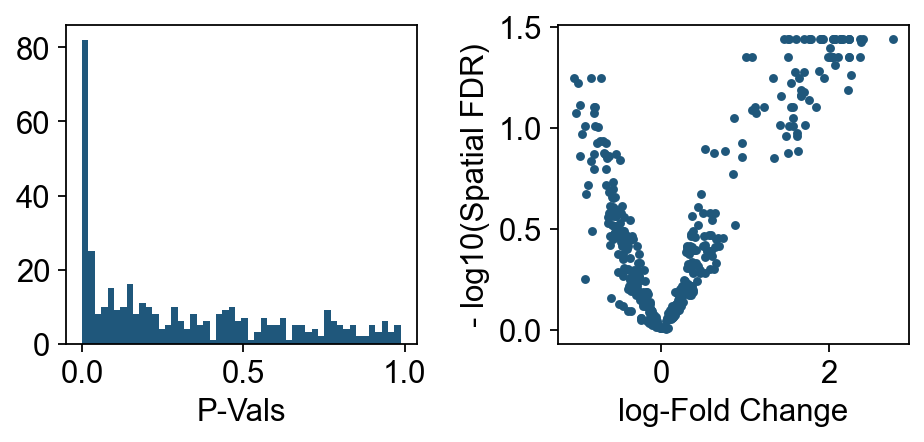

In [6]:
import matplotlib.pyplot as plt
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [6, 3]
plt.subplot(1, 2, 1)
plt.hist(dct_obj.mdata["milo"].var.PValue, bins=50)
plt.xlabel("P-Vals")
plt.subplot(1, 2, 2)
plt.plot(dct_obj.mdata["milo"].var.logFC, -ov.np.log10(dct_obj.mdata["milo"].var.SpatialFDR), ".")
plt.xlabel("log-Fold Change")
plt.ylabel("- log10(Spatial FDR)")
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

We can see that for the majority of neighbourhoods, almost all cells have the same cell type label. We can rename neighbourhoods where less than 60% of the cells have the top label as “Mixed”

Text(0.5, 0, 'celltype fraction')

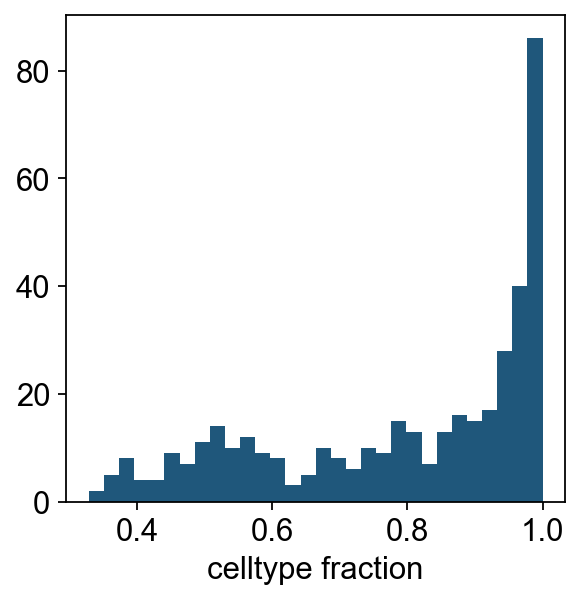

In [7]:
plt.hist(dct_obj.mdata["milo"].var["nhood_annotation_frac"], bins=30)
plt.xlabel("celltype fraction")

In [8]:
res=dct_obj.get_results(mix_threshold=0.6)
res.head()

,index_cell,kth_distance,logFC,lfcSE,logCPM,stat,PValue,FDR,adj_pvalue,SpatialFDR,Nhood_size,nhood_annotation,nhood_annotation_frac
0,B1_AAACGCACTGTCCC_Control_Stem,9.152347,-0.583312,0.051568,11.412487,3.713398,0.080774,0.258990,0.258990,0.256133,399.0,Mixed,0.578947
1,B1_AATAAGCTAGAGAT_Control_Enterocyte.Progenitor,9.476911,-0.809424,0.056194,11.429808,8.896907,0.012736,0.079455,0.079455,0.079067,408.0,Mixed,0.524510
2,B1_ACGCTGCTCTCTTA_Control_Enterocyte.Progenitor,9.004735,1.512198,0.017016,10.817280,12.689494,0.004606,0.045980,0.045980,0.044634,228.0,Mixed,0.557018
3,B1_ACGGAACTGTTAGC_Control_Enterocyte.Progenitor,9.966439,0.673496,0.032412,10.452936,2.316397,0.156838,0.362072,0.362072,0.350619,181.0,Mixed,0.563536
4,B1_ACTTCTGATCGTTT_Control_TA.Early,9.194638,0.202095,0.035912,11.222971,0.404716,0.537956,0.714916,0.714916,0.705203,339.0,TA.Early,0.820059


### Visualization

This is my favorite Milo plot. First, we create a `color_dict` to specify the cell colors we want to visualize.


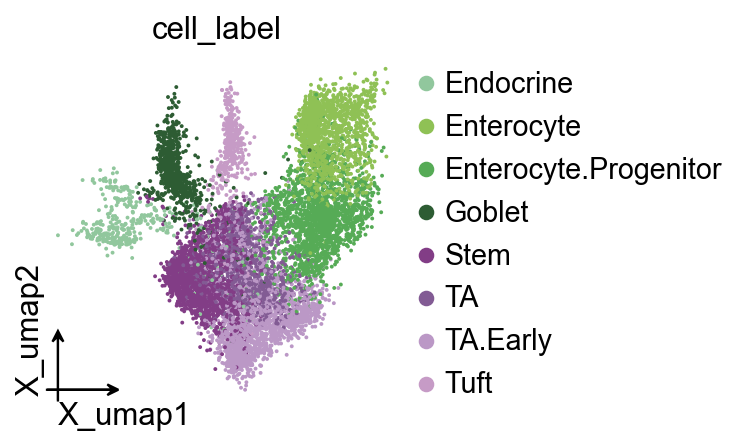

In [18]:
color_dict=dict(zip(
    adata.obs['cell_label'].cat.categories,
    ov.pl.green_color[:4]+ov.pl.purple_color
))
color_dict['Mixed']='#c2c2c2'
fig, ax = plt.subplots(figsize=(3, 3))
ov.pl.embedding(
    adata,
    basis='X_umap',
    color=['cell_label'],
    palette=color_dict,
    ax=ax,
    #fig_size=(3,3)
)

Text(1, -0.75, 'Enriched in\nSalmonella')

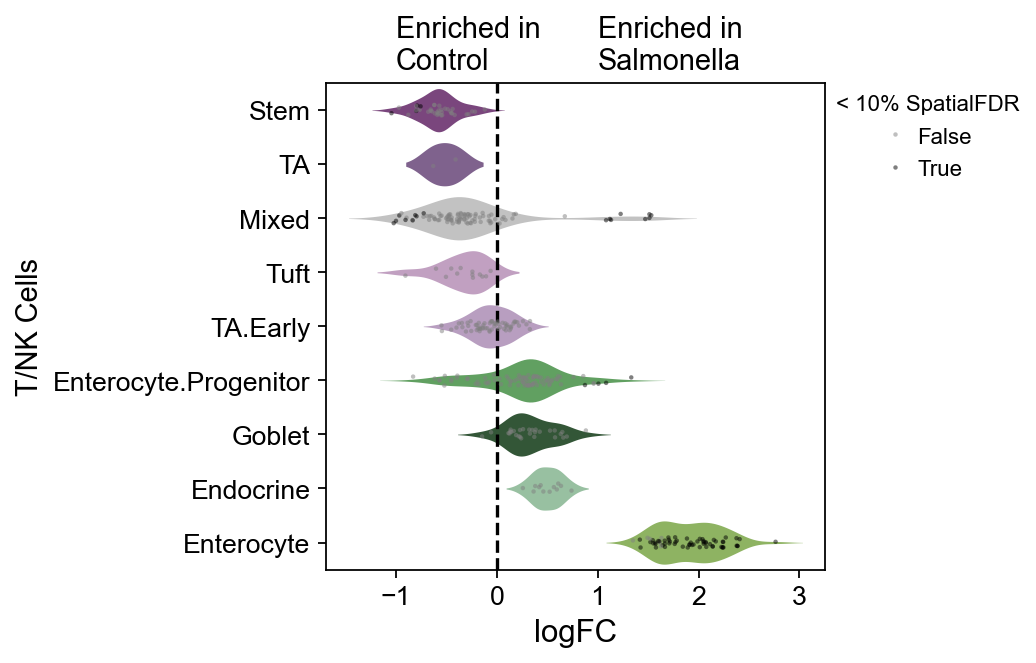

In [10]:
#fig, ax = plt.subplots(figsize=(3, 4))
dct_obj.model.plot_da_beeswarm(
    dct_obj.mdata, 
    alpha=0.1,
    return_fig=True,
    palette=color_dict,
)
ov.plt.xticks(fontsize=12)
ov.plt.yticks(fontsize=12)
ov.plt.ylabel('T/NK Cells',fontsize=13)
ov.plt.text(-1,-0.75,'Enriched in\nControl',fontsize=13)
ov.plt.text(1,-0.75,'Enriched in\nSalmonella',fontsize=13)
#fig

## (Optional) DCT with milo


Tutorials could be found in https://pertpy.readthedocs.io/en/stable/tutorials/notebooks/milo.html

In [11]:
dct_obj_old=ov.single.DCT(
    adata,
    condition='condition',
    ctrl_group='Control',
    test_group='Salmonella',
    cell_type_key='cell_label',
    method='milo',
    sample_key='batch',
    use_rep='X_harmony'
)

2026-02-20 01:28:10 | [INFO] cffi mode is CFFI_MODE.ANY
2026-02-20 01:28:10 | [INFO] R home found: /Library/Frameworks/R.framework/Resources
2026-02-20 01:28:10 | [INFO] R library path: 
2026-02-20 01:28:10 | [INFO] LD_LIBRARY_PATH: 
2026-02-20 01:28:10 | [INFO] Default options to initialize R: rpy2, --quiet, --no-save


✅ Differential cell type abundance analysis initialized
📊 DCT analysis using milo method
📊 Condition: condition, Control group: Control, Test group: Salmonella


2026-02-20 01:28:10 | [INFO] R is already initialized. No need to initialize.


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


In [12]:
dct_obj_old.run()

✅ milo DCT analysis completed


Text(1, -0.75, 'Enriched in\nSalmonella')

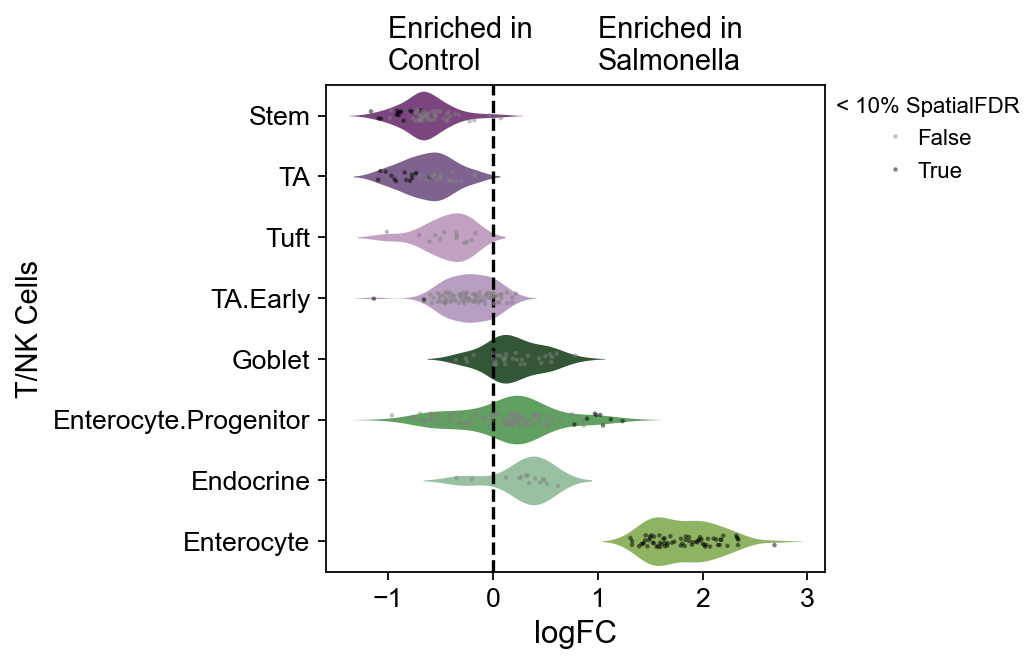

In [14]:
#fig, ax = plt.subplots(figsize=(3, 4))
dct_obj_old.model.plot_da_beeswarm(
    dct_obj_old.mdata, 
    alpha=0.1,
    return_fig=True,
    palette=color_dict,
)
ov.plt.xticks(fontsize=12)
ov.plt.yticks(fontsize=12)
ov.plt.ylabel('T/NK Cells',fontsize=13)
ov.plt.text(-1,-0.75,'Enriched in\nControl',fontsize=13)
ov.plt.text(1,-0.75,'Enriched in\nSalmonella',fontsize=13)
#fig